In [2]:
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns

from pandarallel import pandarallel

pandarallel.initialize()

from arnie.free_energy import free_energy
from arnie.utils import write_constraints

Populating the interactive namespace from numpy and matplotlib
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Replicating some of the analysis done in 

Becker, W. R., Jarmoskaite, I., Kappel, K., Vaidyanathan, P. P., Denny, S. K., Das, R., ... & Herschlag, D. (2019). _Quantitative high-throughput tests of ubiquitous RNA secondary structure prediction algorithms via RNA/protein binding._ BioRxiv, 571588.

https://www.biorxiv.org/content/10.1101/571588v1

In [3]:
df = pd.read_excel("../ExternalDatasets/data/JarmoskaitePUMdata/PUM_data.xlsx")
df = df.dropna(subset=['ddG_25_exp'])
df['Sequence'] = [x.replace('T','U') for x in df['Sequence']]

#find PUM binding motif and write corresponding constraint
df['binding_constraint'] = [write_constraints(seq, motif=('UGUAUAUn','xxxxxxxx')) for seq in df['Sequence']]

#what do these look like?
print(df['Sequence'][1])
print(df['binding_constraint'][1])

UUUUAUUCCACCACCCCCUUGUAUAUAUUU
...................xxxxxxxx...


In [4]:
pkg_options = {'vienna_2':{'package':'vienna'},
               'vienna_2_25':{'package':'vienna', 'T':25},
               'vienna_2_60':{'package':'vienna', 'T':60},
              'contrafold':{'package':'contrafold'}}
              #'eternafold':{'package':'contrafold','param_file':'EternaFoldParams/params.v1'}}

for pkg, options_dct in pkg_options.items():
    df['dG_%s' % pkg] = df.parallel_apply(lambda row: free_energy(row['Sequence'], **options_dct), axis=1)
    df['dG_constr_%s' % pkg] = df.parallel_apply(lambda row: free_energy(row['Sequence'], **options_dct, constraint=row['binding_constraint']), axis=1)
    df['ddG_%s' % pkg] = df['dG_constr_%s' % pkg] - df['dG_%s' % pkg]

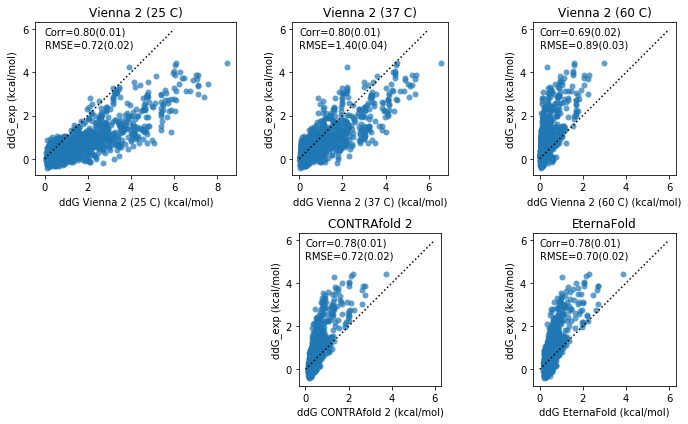

In [39]:
def plot_diag(): plot([0,6],[0,6],linestyle=':',c='k')
    
def rmse(x,y):
    return np.sqrt(np.mean(np.square(x-y)))

figure(figsize=(10,6))
      
titles=['Vienna 2 (25 C)','Vienna 2 (37 C)','Vienna 2 (60 C)','CONTRAfold 2', 'EternaFold']

ctr=1
for i, pkg in enumerate(['vienna_2_25', 'vienna_2', 'vienna_2_60', 'contrafold', 'eternafold']):
    

        
    #print("%s %.3f %.3f" %(pkg, np.mean(lst), np.std(lst)))
    
    subplot(2,3,ctr,aspect='equal')
    C = np.corrcoef(df['ddG_25_exp'], df['ddG_%s' % pkg])[0][1]
    title(titles[i])
    text(0,5.15,"RMSE=%.2f(%.2f)" % (np.mean(rms[:,i]), np.std(rms[:,i])))
    text(0,5.75,"Corr=%.2f(%.2f)" % (np.mean(corr[:,i]), np.std(corr[:,i])))

    sns.scatterplot(x='ddG_%s' % pkg, y='ddG_25_exp', data=df, linewidth=0, alpha=0.7)
    xlabel("ddG %s (kcal/mol)"% titles[i])
    ylabel("ddG_exp (kcal/mol)")
    ctr+=1
    if ctr==4:
        ctr+=1
    plot_diag()
    
tight_layout()
savefig('PUM_comparison.pdf',bbox_inches='tight')

In [27]:
def bootstrap_inds(len_item):
    return np.random.choice(range(len_item), len_item)

def rmse(x,y):
    return np.sqrt(np.mean(np.square(x-y)))

n_bootstraps=1000

rms = np.zeros([n_bootstraps,5])
corr = np.zeros([n_bootstraps,5])

for j in range(n_bootstraps):
    lst=[]
    bs_inds = bootstrap_inds(len(df))

    for i, pkg in enumerate(['vienna_2', 'vienna_2_25','vienna_2_60','contrafold', 'eternafold']):

        x = df['ddG_25_exp'].values[bs_inds]
        y = df['ddG_%s' % pkg].values[bs_inds]
        c = np.corrcoef(x,y)[0][1]
        r = rmse(x,y)
        rms[j,i] = r
        corr[j,i] = c

In [45]:
# export bootstrap correlations for main text plot
corr_df = pd.DataFrame({'Corr': np.concatenate([corr[:,0],corr[:,3],corr[:,4]]),
                        'package':['vienna_2']*1000+['contrafold_2']*1000+['eternafold_B']*1000,
                        'ID':['PUM']*3000})
corr_df.to_json('PUM_correlation_bootstraps.json')